<br>
# **Word 2 Vec**
1. 자연어에서 딥러닝의 활용 : Machine Learning for Natural Langua https://www.lucypark.kr/docs/2015-pyconkr/#1

<br>
## **1 데이터 임베딩과 표상학습**
임베딩 : 복잡한 원시 데이터(raw data)를 컴퓨터가 학습을 통해서 생성한(computer-generated) 축소된 숫자값의 목록
1. **tf-idf** : 벡터화에 바탕을 둔 **용어빈도 - 역 문서 빈도** 를 활용
1. **PCA** : 차원의 저주를 극복하기 위해 **기본 데이터를 압축**하는 방법으로써 활용
1. **One-hot Encoding** : 개별 Factor 간의 구별은 가능하지만, 의미적 유사도를 알기는 어렵다
1. **Word2Vec** : Mikolov가 고안한 방법으로 "주변 단어를 보면 그 단어를 알 수 있다" (John Firth)

<br>
## **2 Word 2 Vector** <small>https://ronxin.github.io/wevi/</small>
**단어의 분포**를 **고밀도 vector**로 표현하고, **단어간의 유사도**는 **Cosin 측정방법(벡터의 내적)**으로 수치화 한다

1. 2013년 구글에서 개발한 기법
1. **Skip Gram** : 사용자가 원하는 target 데이터를 추측하고, 이를 기초로 문맥의 요소들을 예측한다
1. **Continuous Bag of Word** : 전체 문맥의 어휘들로 요소를 만들고, 목표인 Target을 예측하기 위해 모델을 생성한다
1. **V to ln(V)** (Complexity Reduction) : 단어의 갯수에 따라 늘어나느 계산량을 줄이기 위해, 


<img src="https://www.lucypark.kr/docs/2015-pyconkr/w2v.png" align='left' width='600'>

<br>
### **CBOW (Continuous Bag-of-Words 모델)**
1. **원하는 대상 주변**의 token을 대상으로 모델을 생성
1. 문장의 **여러 단어들 가운데**, 빈 단어를 채운다
1. 주어진 단어 앞뒤로 여유분의 token을 선택하고
1. 이들을 활용하여 적합한 내용을 유추하는 Network를 생성한다

<br>
### **skip-gram 모델**
1. **주어진 token**을 갖고서 **주위의 단어들을 유추**한다
1. **단어간의 빈도**를 활용하여가까운 단어일수록 가깝고, 먼 단어일수록 빈도가 낮음을 활용한다
1. 위의 CBOW와 같은 모델연산을 요하지만
1. **샘플링 기준이 되는 단어를 몇개**로 정하는지에 따라 연산시간이 많이 차이난다 (다양한 기법들을 활용가능)
1. 실무에서는 CBOW 보단 **skip-gram**이 더 좋은 결과를 보여준다

<br>
### **Tensorflow 를 활용한 Word2Vec**
텐서플로를 활용하여 Skip-Gram 기법을 활용하여 Word2Vec 만들기

In [1]:
# 독일 퀘르버 재단 연설문 : 베를린 선언
# 문서 불러오기
f     = open('./data/베를린선언.txt', 'r')
texts_Berlin_raw = f.read()
f.close()
texts_Berlin = texts_Berlin_raw.split('\n\n')

In [2]:
# Stop Word 전처리
import string
punct = string.punctuation
punct = [punct[i] for i in range(len(punct))]
punct = punct + ['\n', ')', '(']

# 불필요한 기호들을 제거한다
for dump in punct: 
    texts_Berlin = [txt.replace(dump, '')    for txt in texts_Berlin]
print(len(texts_Berlin))

In [3]:
# word_sequence : 단어 배열 원본 
# word_list     : 단어 배열 중복제거
# word_dict     : word_list의 인덱스 배열을 생성 

word_sequence = " ".join(texts_Berlin).split()
word_list     = " ".join(texts_Berlin).split()
word_list     = list(set(word_list))
word_dict     = {w: i for i, w in enumerate(word_list)}

In [4]:
# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
import numpy as np

# skip-gram을 만든 후, 고유 번호(index)를 저장
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target  = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
    for w in context:
        skip_grams.append([target, w])

In [5]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성
def random_batch(data, size):
    random_inputs, random_labels = [], []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    for i in random_index:
        random_inputs.append(data[i][0])    # target
        random_labels.append([data[i][1]])  # context word
    return random_inputs, random_labels

In [6]:
training_epoch = 300
learning_rate  = 0.1
batch_size     = 20
embedding_size = 2   # 단어벡터 임베딩 차원 (x, y 2개만 출력)
num_sampled    = 15  # 모델의 nce_loss 샘플크기 (batch_size 보다 작아야 한다)
voc_size       = len(word_list) # 총 단어 갯수

In [7]:
inputs = tf.placeholder(tf.int32, shape=[batch_size])
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과를 저장할 임베딩 벡터를 정의
embeddings     = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases  = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수는 tf.nn.nce_loss 함수를 사용
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [8]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)
        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})
        if step % 30 == 0:
            print("loss at step ", step, ": ", loss_val)
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()

loss at step  30 :  41.542034
loss at step  60 :  41.47303
loss at step  90 :  25.07451
loss at step  120 :  33.435047
loss at step  150 :  32.99861
loss at step  180 :  10.731102
loss at step  210 :  36.63857
loss at step  240 :  22.269367
loss at step  270 :  32.060616
loss at step  300 :  13.882846


In [9]:
%matplotlib inline
from matplotlib import font_manager, rc
font_fname = './data/D2Coding.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

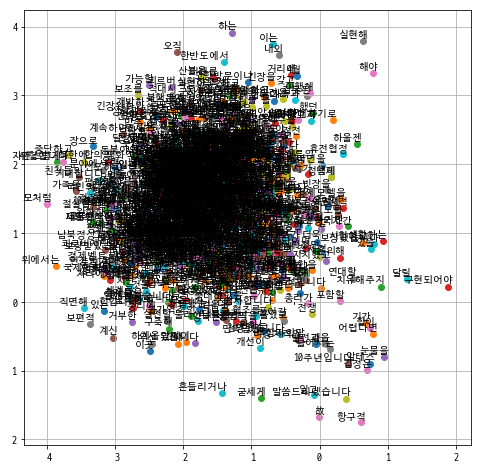

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.grid(True)
plt.show()

<br>
# **gensim**
1. https://radimrehurek.com/gensim/
1. Why is Gensim Word2Vec so much faster than Keras GPU? [link](https://www.reddit.com/r/learnmachinelearning/comments/88eeua/why_is_gensim_word2vec_so_much_faster_than_keras/)
1. word to Vec 모델 만들기
1. 만들어진 모델을 저장하기
1. 저장된 모델을 사용하여 단어간 유사한 그룹 출력하기


<br>
## **1 Word to Vector**
**from** gensim.models **import** Word2Vec

**Word2Vec**(tokenized_contents, size=100, window = 2, min_count=50, workers=4, iter=100, sg=1)
1. **size = 100** : 태깅된 Token들을 100차원의 벡터로 변환 (너무 많으면 차원의 저주에 빠진다)
1. **window = 2** : 주변 단어(window)는 앞뒤로 두개 까지만 포함 (Skip-Gram)
1. **min_count=50** :  코퍼스 내 출현 빈도가 50번 미만인 단어는 분석에서 제외
1. **iter=100** : CPU는 쿼드코어를 활용하여 100번 반복 학습한다 (Multi Thread)
1. **sg=1** : 분석방법으로는 CBOW, Skip-Gram 중 **Skip-Gram**를 선택

<br>
### **01 word 2 vec 데이터 만들기**
gensim

In [11]:
%%time
# 텍스트를 한 줄씩 문법 tag를 추가한다
results, lines = [], texts_Berlin
from konlpy.tag import Twitter
twitter = Twitter()

for line in lines:
    malist = twitter.pos(line, norm=True, stem=True)
    result = [ word[0]   for word in malist    # 어미/조사/구두점 제외
               if not word[1] in ["Eomi", "Josa", "Punctuation"] ]
    rl = (" ".join(result)).strip()
    results.append(rl)
    
texts_file = './data/Berlin.tagged'
with open(texts_file, 'w', encoding='utf-8') as fp:
    fp.write("\n".join(results))

CPU times: user 5.85 s, sys: 134 ms, total: 5.99 s
Wall time: 2.07 s


In [12]:
! cat ./data/Berlin.tagged | head -n 5

존경 하다 독일 국민 여러분
고국 계시다 국민 여러분
하울 젠 쾨르버 재단 이사 님 모드 전 동독 총리 님 비롯 하다 내외 귀빈 여러분
먼저 냉전 분단 넘다 통일 이루다
그 힘 유럽 통합 국제 평화 선도 있다


In [13]:
%%time
# Word2Vec 데이터 모델을 학습한 뒤 저장한다
from gensim.models import word2vec
data  = word2vec.LineSentence(texts_file)
model = word2vec.Word2Vec(data, size=200, window=10, hs=1, min_count=2, sg=1)
model.save("./data/Berlin.model")
print("ok")

ok
CPU times: user 304 ms, sys: 27.8 ms, total: 332 ms
Wall time: 325 ms


<br>
### **02 저장된 모델을 활용하기**
gensim

In [14]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./data/Berlin.model')

In [15]:
model.wv.most_similar(positive=['한반도'])

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('적', 0.9921074509620667),
 ('하다', 0.9911549091339111),
 ('있다', 0.9908924698829651),
 ('정치', 0.9889532327651978),
 ('경제', 0.9877470135688782),
 ('군사', 0.9866889715194702),
 ('이다', 0.9864642024040222),
 ('것', 0.9863808155059814),
 ('수', 0.9858399629592896),
 ('세계', 0.9850960969924927)]

In [16]:
model.wv.most_similar(positive=['통일'])

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.9850492477416992),
 ('한반도', 0.9841077327728271),
 ('있다', 0.9835944771766663),
 ('적', 0.9833388924598694),
 ('것', 0.9806991219520569),
 ('정치', 0.9793907999992371),
 ('되다', 0.978852391242981),
 ('세계', 0.9786710143089294),
 ('이다', 0.9784707427024841),
 ('독일', 0.9781535267829895)]

In [17]:
model.wv.most_similar(positive=['정치'])

/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.9892142415046692),
 ('적', 0.9890828728675842),
 ('한반도', 0.9889532327651978),
 ('있다', 0.9880016446113586),
 ('군사', 0.9872136116027832),
 ('째', 0.9842973947525024),
 ('이다', 0.9842597246170044),
 ('수', 0.9839317202568054),
 ('교류', 0.9838070869445801),
 ('사업', 0.9829899668693542)]

<br>
### **03 Visulaization**
gensim

In [18]:
# model.wv.vocab : { word: object of numeric vector } 를 출력한다
vocab = list(model.wv.vocab)
X = model[vocab]

/home/markbaum/Python/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# 이번 모델의 경우에는 100차원의 벡터로 구성되어 있지만
# 이를 시각화 하기에는 부적절 하므로 (3차원 이상은 시각화가 불가능)
# 2차원의 데이터로 변환하는 sklearn 의 TSNE 모듈을 사용한다 (각 차원별의 유사도는 배색의 차이를 사용하여 출력한다) 
from sklearn.manifold import TSNE
# TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [20]:
import pandas as pd
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.head()

,x,y
존경,-4.606161,20.196222
하다,10.832066,-31.455429
독일,8.204652,-25.016357
국민,0.821778,0.014622
여러분,10.564078,-25.377256


/home/markbaum/Python/python/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


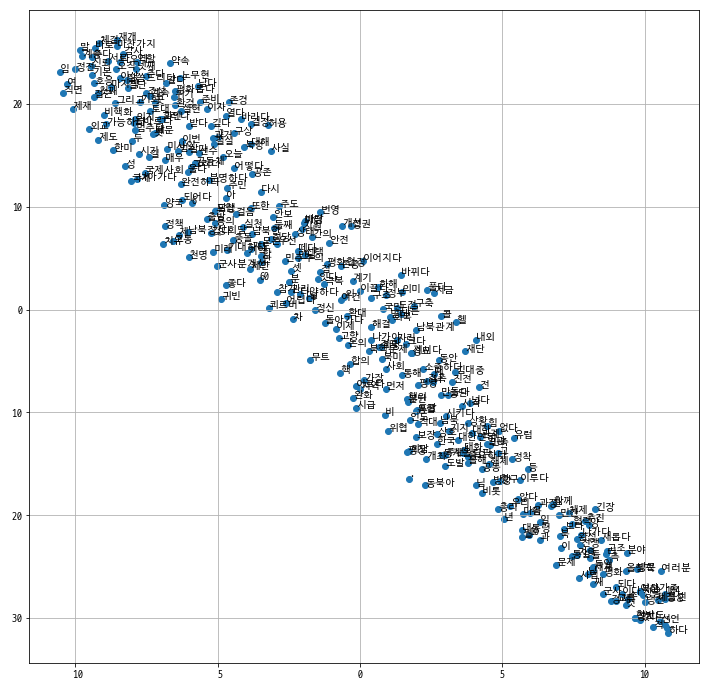

In [21]:
%matplotlib inline
from matplotlib import font_manager, rc
font_fname = './data/D2Coding.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.grid(True)
ax  = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

<br>
## **2 Gensim을 활한 네이버 긍정/부정 단어모델 만들기**
1. 앞에서 nltk 모듈을 활용하여 나이브 베이지안 분류기(Naive Bayesian Classifier) 분류 모델을 만들었다
1. nltk에서는 Bag of Word 를 활용하여 단어의 빈도 데이터를 생성하고
1. 이를 바탕으로 Naive Bayesian Classifier 모델을 학습, 이를 활용하였다
1. 분류가 명확한 대상을 구분하기 위한 모델로써는 적합하지만
1. 모델 내부구조를 살펴보면서, 단어간의 관계 유사도를 파악하기는 어려운 단점이 존재한다
1. Word2Vec 를 활용하여 베이지안 모델에서 변별력이 높은 데이터와 유사관계에 불필요한 단어가 포함되었는지를 분석한다
1. 목적인 긍/부정에 혼동/방해가 되는 단어들이 있는지를 파악한 뒤, 해당 단어를 제어/ 보완을 한 뒤 베이지안 분류모델을 다시 학습한다
1. Word2Vec 모델은 나이브베이지안 모델의 보완재로써 활용 가능하다 
# gensim 모델의 오류수정 : http://daewonyoon.tistory.com/240
# https://github.com/hoho0443/classify_comment_emotion

<br>
### **01 분석을 위한 모델과 데이터 정의하기**
gensim

In [6]:
from konlpy.tag import Twitter
twitter = Twitter()

def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/50)) ]
    return random_data

def tokenize(doc):
  # norm, stem은 optional
  return ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)]

In [7]:
# Doc2Vec 에 활용할 파라미터를 정의한다
import multiprocessing
cores = multiprocessing.cpu_count()
worker_count = cores
vector_size = 300
window_size = 15
word_min_count = 2
sampling_threshold = 1e-5
negative_size = 5
train_epoch = 100
dm = 1

<br>
### **02 네이버 리뷰 데이터를 모델과 연결하여 학습**
gensim

In [8]:
from collections import namedtuple
# 트래이닝 데이터 읽기
train_data = read_data('data/ratings_train.txt')
# 형태소 태그 추가하기
train_docs = [(tokenize(row[1]), row[2]) for row in train_data[1:]]
# doc2vec 에서 필요한 데이터 형식으로 변경
# 단어와 태그를 Tuple 의 형식으로 변환한다
TaggedDocument    = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]

In [9]:
%%time
# 태그가 추가된 token을 활용하여 Doc2Vec 모델 정의하기
from gensim.models import doc2vec
doc_vectorizer = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(tagged_train_docs)

# Train document vectors!
# 위에서 정의된 doc2Vec 모델을 반복 훈련하기
for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, 
                         total_examples = doc_vectorizer.corpus_count, 
                         epochs = doc_vectorizer.epochs)
    doc_vectorizer.alpha -= 0.002                    # learning rate 의 증감률을 재 정의한다
    doc_vectorizer.min_alpha = doc_vectorizer.alpha  # 재정의된 증감률로 모델을 Update 한다

# 학습이 완료된 모델의 데이터를 저장한다
doc_vectorizer.save('data/doc2vec.model')

CPU times: user 8.83 s, sys: 663 ms, total: 9.5 s
Wall time: 5.21 s


<br>
### **03 저장된 학습 모델을 활용하기**
gensim

<img src="https://www.lucypark.kr/docs/2015-pyconkr/regularities.png" align='left' width='500'>

In [10]:
# 저장된 모델을 호출하여 활용한다
from gensim.models import doc2vec
from pprint import pprint
doc_vectorizer = doc2vec.Doc2Vec.load('data/doc2vec.model')
pprint(doc_vectorizer.wv.most_similar('공포/Noun'))

[('시리즈/Noun', 0.7168623805046082),
 ('에겐/Josa', 0.7058377265930176),
 ('에서/Noun', 0.67695552110672),
 ('중/Suffix', 0.6729834079742432),
 ('SF/Alpha', 0.6674826145172119),
 ('초등학교/Noun', 0.6674530506134033),
 ('메다/Verb', 0.6669254899024963),
 ('공포영화/Noun', 0.664033055305481),
 ('역대/Noun', 0.6585553288459778),
 ('칼/Noun', 0.6533156037330627)]


/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [12]:
pprint(doc_vectorizer.wv.most_similar('공포영화/Noun'))

[('역대/Noun', 0.7458347678184509),
 ('종영/Noun', 0.7260103225708008),
 ('그만/Adverb', 0.7142369747161865),
 ('예산/Noun', 0.7111532688140869),
 ('늘어지다/Verb', 0.7105023264884949),
 ('질/Noun', 0.7036303281784058),
 ('ㄷㄷ/KoreanParticle', 0.6967483758926392),
 ('나서다/Verb', 0.6965490579605103),
 ('무조건/Noun', 0.6940554976463318),
 ('시리즈/Noun', 0.6899343729019165)]


/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [14]:
pprint(doc_vectorizer.wv.similarity('공포/Noun', 'ㅋㅋ/KoreanParticle'))

0.12617816


/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [13]:
# 단어간의 단순한 거리 뿐만이 아니라, 긍/부정 관계망도 분석 가능하다
# 하지만 이는 수차상의 관계이지, 이상치가 나타면 이유를 알기 위해선 사람이 보고 판단을 해야 하는 노가다를 요한다
pprint(doc_vectorizer.wv.most_similar(positive=['여자/Noun', '천재/Noun'], negative=['남자/Noun']))

[('역사/Noun', 0.700955867767334),
 ('스럽다/Adjective', 0.6684340238571167),
 ('억지/Noun', 0.6651149392127991),
 ('인간/Noun', 0.650126576423645),
 ('범인/Noun', 0.6470707058906555),
 ('속편/Noun', 0.6458727121353149),
 ('올/NounPrefix', 0.6397019028663635),
 ('폭력/Noun', 0.6336144804954529),
 ('술/Noun', 0.6175847053527832),
 ('역/Noun', 0.6074761748313904)]


/home/markbaum/Python/python/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


<br>
### **04 Word2Vec 의 성능 비교하기**
gensim


In [16]:
from collections import namedtuple
# 트래이닝 데이터 읽기
train_data = read_data('data/ratings_train.txt')
train_docs = [(tokenize(row[1]), row[2]) for row in train_data[1:]]
TaggedDocument    = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]

# 테스트 데이터 읽기
test_data = read_data('data/ratings_test.txt')
test_docs = [(tokenize(row[1]), row[2]) for row in test_data[1:]]
TaggedDocument    = namedtuple('TaggedDocument', 'words tags')
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

In [17]:
# 축약해서 생성한 모델을 원본 데이터로 검증을 하고
# 모델의 형태또한 다르다 보니 term existance와는 공평한 비교는 아닐 수 있다 
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]
test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]

300

In [18]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x, train_y)
classifier.score(test_x, test_y)
# => 0.78246000000000004

0.6866866866866866

### 02.ml_for_nltk
word2Vec
1. Gensim
1. Tensorflow
1. tSNE

RNN
1. 삼행시 봇

LSTM 문장생성
1. HMM 은 유사도만 측정 가능하고, 그 확률이 낮아서 문장생성은 어렵다
1. LSTM도 낮은 확률에 근거하여 Text를 생성하지만, 반복 학습을 통해서 오차를 줄이는 과정을 통해 정밀성을 높일 수 있다

seq2seq 챗봇
1. Text 생성
1. 어린왕자 Text를 대통령 연설문으로 바꿔서 챗봇 구현하기

Attention
1. Image Detection